# Rapid Refresh Model Plotting 

This notebook gives several examples of plotting model analyses from the RAP model.

In [105]:
#Required Libraries
from datetime import datetime, timedelta

from model_functions import *

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors

from metpy.plots import StationPlot
from metpy.units import units
import metpy.calc as mpcalc

import numpy as np

from netCDF4 import Dataset, num2date

from scipy.ndimage import gaussian_filter

from xarray.backends import NetCDF4DataStore
import xarray as xr

import pandas as pd

In [113]:
#set time to plot (no leading zeros)
start_year  = 2023
start_month = 3
start_day   = 17
start_hour  = 12
start_min   = 0
    
#location to plot
#location = True
location_lat = 45.5
location_lon = -93.5
#    OR
#analysis bounds
location = False
lat_min = 25
lat_max = 50
lon_min = -105
lon_max = -75

In [114]:
dt = datetime(start_year,start_month,start_day,start_hour)
ncss = get_rap_dataset(dt)
#print(ncss)
#for i in ncss.variables:
#    if "isobaric" in i:
#        print(i)

https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/202303/20230317/catalog.xml


In [115]:
query = ncss.query()
query.lonlat_box(north=lat_max,south=lat_min,east=lon_max,west=lon_min)
query.all_times()
query.add_lonlat()
query.accept('netcdf')
query.variables('Relative_humidity_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric',
                'Temperature_isobaric',
                'Geopotential_height_isobaric'
)
data = ncss.get_data(query)
ds = xr.open_dataset(NetCDF4DataStore(data)).metpy.parse_cf()

In [116]:
dwpt = mpcalc.dewpoint_from_relative_humidity(ds.Temperature_isobaric, ds.Relative_humidity_isobaric)
spec_humidity = mpcalc.specific_humidity_from_dewpoint(ds.isobaric, dwpt)

print(ds.isobaric.shape)

(37,)


In [117]:
isent_levs = np.arange(290,321,2) * units.kelvin

#get isentropic data
isen_ds = mpcalc.isentropic_interpolation_as_dataset(
    isent_levs,
    ds.Temperature_isobaric[0],
    ds.Geopotential_height_isobaric[0],
    ds.Relative_humidity_isobaric[0],
    ds['u-component_of_wind_isobaric'][0],
    ds['v-component_of_wind_isobaric'][0]
)

#smooth parameters
isen_ds['pressure'] = mpcalc.smooth_n_point(isen_ds.pressure, 9, 10)
isen_ds['Relative_humidity_isobaric'] = mpcalc.smooth_n_point(isen_ds.Relative_humidity_isobaric, 9, 10)
isen_ds['temperature'] = mpcalc.smooth_n_point(isen_ds.temperature, 9, 10)
isen_ds['Geopotential_height_isobaric'] = mpcalc.smooth_n_point(isen_ds.Geopotential_height_isobaric, 9, 10)

/research/modules/mpich/miniconda3/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:152: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


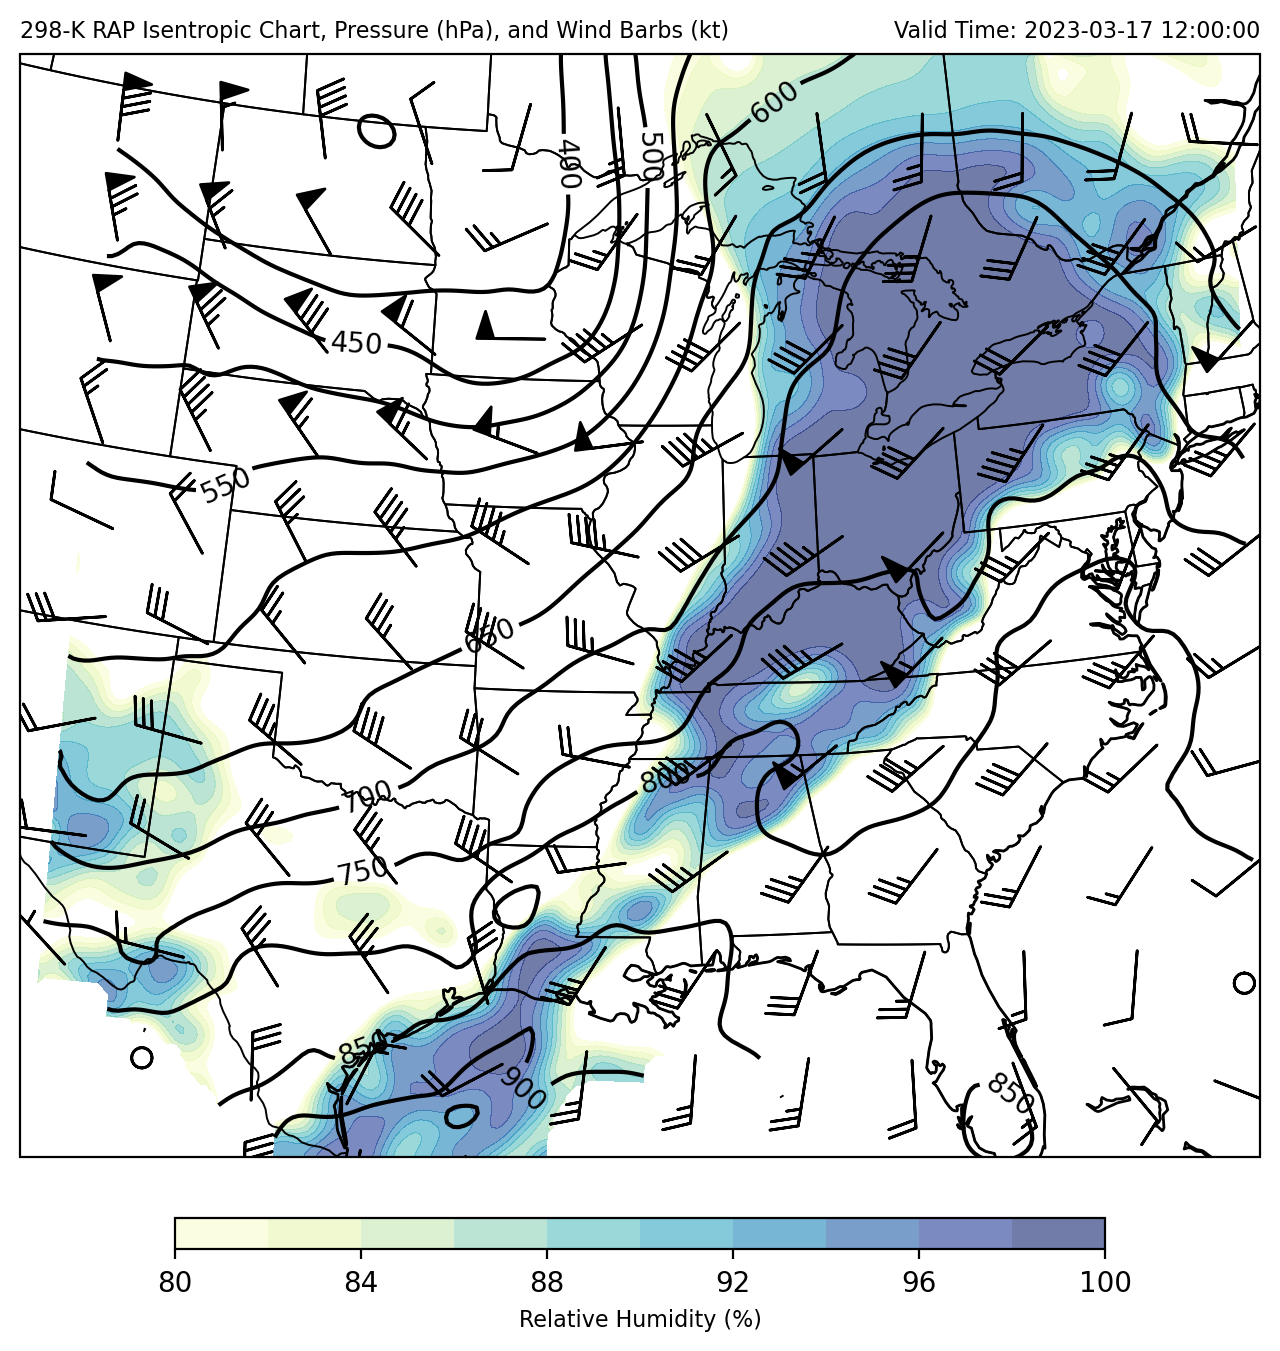

In [122]:
isen_level = 298*units.kelvin

proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)


fig = plt.figure(figsize=(8,8),dpi=200)
ax = fig.add_subplot(1,1,1,projection=proj)

cs = ax.contour(ds.lon,ds.lat,isen_ds.pressure.metpy.sel(isentropic_level=isen_level),
                   np.arange(100,1100,50),colors='black',transform=ccrs.PlateCarree())
ax.clabel(cs,inline=True,fmt=lambda v: format(v,'.0f')[:3],zorder=10)

cf = ax.contourf(ds.lon,ds.lat,isen_ds.Relative_humidity_isobaric.metpy.sel(isentropic_level=isen_level),
                   np.arange(80,101,2),cmap='YlGnBu',alpha=0.6,transform=ccrs.PlateCarree())
plt.colorbar(cf,orientation="horizontal", pad=0.05, shrink=0.75, fraction=0.05, aspect=30).set_label(label='Relative Humidity (%)',size=8)

wind_slice = (slice(None,None,20),slice(None,None,20))
wb = ax.barbs(ds.lon[wind_slice].values,ds.lat[wind_slice].values,
            isen_ds["u-component_of_wind_isobaric"].metpy.sel(isentropic_level=isen_level)[wind_slice].metpy.convert_units('kts').values,
            isen_ds["v-component_of_wind_isobaric"].metpy.sel(isentropic_level=isen_level)[wind_slice].metpy.convert_units('kts').values,
            length=7,lw=1,pivot='middle',color='black',transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

plt.title(f'{isen_level.magnitude}-K RAP Isentropic Chart, Pressure (hPa), '
          'and Wind Barbs (kt)', loc='left',fontsize=8)
vtime = ds.time[0].data.astype('datetime64[ms]').astype('O')
plt.title('Valid Time: {}'.format(vtime), loc='right',fontsize=8)
plt.savefig('isentropic_chart.png',bbox_inches='tight')